In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

np.set_printoptions(suppress=True)

In [14]:
raw_data = pd.read_csv('ML-MATT-CompetitionQT1920_train.csv', encoding='unicode_escape')
display(raw_data.head())
print(raw_data.Unusual.value_counts())

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0,7.0,1
1,9:45,1BLTE,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0,10.0,1
2,7:45,9BLTE,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0,2.0,1
3,2:45,4ALTE,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0,4.0,1
4,3:30,10BLTE,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0,3.0,0


0    26721
1    10183
Name: Unusual, dtype: int64


In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36904 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36904 non-null  object 
 1   CellName     36904 non-null  object 
 2   PRBUsageUL   36904 non-null  float64
 3   PRBUsageDL   36904 non-null  float64
 4   meanThr_DL   36904 non-null  float64
 5   meanThr_UL   36904 non-null  float64
 6   maxThr_DL    36904 non-null  float64
 7   maxThr_UL    36904 non-null  float64
 8   meanUE_DL    36904 non-null  float64
 9   meanUE_UL    36904 non-null  float64
 10  maxUE_DL     36815 non-null  float64
 11  maxUE_UL     36815 non-null  float64
 12  maxUE_UL+DL  36815 non-null  float64
 13  Unusual      36904 non-null  int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 3.9+ MB


In [16]:
data = raw_data.dropna()

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36815 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36815 non-null  object 
 1   CellName     36815 non-null  object 
 2   PRBUsageUL   36815 non-null  float64
 3   PRBUsageDL   36815 non-null  float64
 4   meanThr_DL   36815 non-null  float64
 5   meanThr_UL   36815 non-null  float64
 6   maxThr_DL    36815 non-null  float64
 7   maxThr_UL    36815 non-null  float64
 8   meanUE_DL    36815 non-null  float64
 9   meanUE_UL    36815 non-null  float64
 10  maxUE_DL     36815 non-null  float64
 11  maxUE_UL     36815 non-null  float64
 12  maxUE_UL+DL  36815 non-null  float64
 13  Unusual      36815 non-null  int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 4.2+ MB


In [18]:
del data['Time']

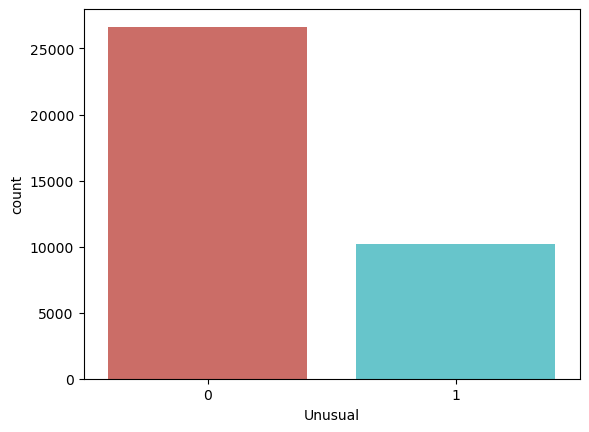

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Unusual',data=data, palette='hls')
plt.show()
#plt.savefig('count_plot') mal: the nodule malignancy, 0: benign, 1: malignant

In [24]:
# Import label encoder 
from sklearn import preprocessing 

# label_encoder object knows 
# how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in column 'species'. 
data['CellName']= label_encoder.fit_transform(data['CellName']) 

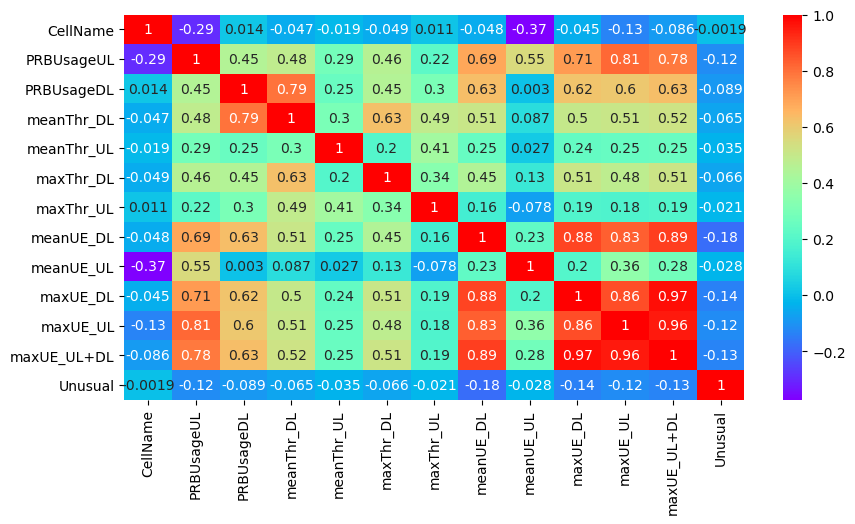

In [25]:
plt.figure(figsize = (10,5))
sns.heatmap(data.corr(), annot = True, cmap="rainbow")
plt.show()

In [39]:
ML_Model = []
accuracy = []
precision = []
f1score = []
recall = []


#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Data Splitting 

In [28]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('Unusual',axis=1), data.Unusual, test_size=0.15, stratify=data.Unusual)

In [29]:
train_min = x_train.min()
train_max = x_train.max()
x_train = (x_train - train_min) / (train_max - train_min)
x_test = (x_test - train_min) / (train_max - train_min)

In [30]:
positives = x_train[y_train == 1]
negatives = x_train[y_train == 0]

# Autoencoder

In [31]:
## input layer 
input_layer = Input(shape=negatives.shape[1:])

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(75, activation='tanh')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(50, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(25, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(7, activation='relu')(encoded)

## decoding part
decoded = Dense(7, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(25, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(50, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(75, activation='tanh')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(negatives.shape[1], activation='relu')(decoded)

In [32]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [34]:
autoencoder.fit(negatives, negatives, batch_size = 4, epochs = 5, shuffle = True)

Epoch 1/5
5663/5663 [==============================] - 100s 18ms/step - loss: 0.1821
Epoch 2/5
5663/5663 [==============================] - 101s 18ms/step - loss: 0.1428
Epoch 3/5
5663/5663 [==============================] - 100s 18ms/step - loss: 0.1204
Epoch 4/5
5663/5663 [==============================] - 99s 18ms/step - loss: 0.1054
Epoch 5/5
5663/5663 [==============================] - 101s 18ms/step - loss: 0.0957


In [35]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])
hidden_representation.add(autoencoder.layers[5])
hidden_representation.add(autoencoder.layers[6])
hidden_representation.add(autoencoder.layers[7])
hidden_representation.add(autoencoder.layers[8])
hidden_representation.add(autoencoder.layers[9])

In [36]:
x_train_transformed = hidden_representation.predict(x_train)
x_test_transformed = hidden_representation.predict(x_test)

173/173 [==============================] - 0s 2ms/step


In [37]:
predictor = Sequential()
predictor.add(Dense(64, activation='relu', input_shape=x_train_transformed.shape[1:]))
predictor.add(BatchNormalization())
predictor.add(Dropout(0.25))
predictor.add(Dense(64, activation='relu'))
predictor.add(BatchNormalization())
predictor.add(Dense(64, activation='relu'))
predictor.add(BatchNormalization())
predictor.add(Dense(64, activation='tanh'))
predictor.add(BatchNormalization())
predictor.add(Dense(1, activation='sigmoid'))

In [38]:
predictor.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
predictor.fit(x_train_transformed, y_train, batch_size=4, epochs=5, shuffle=True)

Epoch 1/5
7823/7823 [==============================] - 78s 10ms/step - loss: 0.5981 - accuracy: 0.7133
Epoch 2/5
7823/7823 [==============================] - 73s 9ms/step - loss: 0.5852 - accuracy: 0.7235
Epoch 3/5
7823/7823 [==============================] - 74s 9ms/step - loss: 0.5823 - accuracy: 0.7239
Epoch 4/5
7823/7823 [==============================] - 76s 10ms/step - loss: 0.5811 - accuracy: 0.7238
Epoch 5/5
7823/7823 [==============================] - 76s 10ms/step - loss: 0.5797 - accuracy: 0.7238


In [41]:
y_predict = predictor.predict(x_test_transformed)

173/173 [==============================] - 0s 2ms/step


In [42]:
print(classification_report(y_test, y_predict >= 0.35))

              precision    recall  f1-score   support

           0       0.75      0.85      0.79      3998
           1       0.38      0.24      0.30      1525

    accuracy                           0.68      5523
   macro avg       0.56      0.55      0.55      5523
weighted avg       0.65      0.68      0.66      5523



In [43]:
dl_acc = accuracy_score(y_test, y_predict >= 0.35)
dl_prec = precision_score(y_test, y_predict >= 0.35)
dl_rec = recall_score(y_test, y_predict >= 0.35)
dl_f1 = f1_score(y_test, y_predict >= 0.35)

In [44]:
storeResults('Autoencoder',dl_acc,dl_prec,dl_rec,dl_f1)

For ML

In [45]:
X = data.drop(["Unusual"],axis =1)
y = data["Unusual"]

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((29452, 12), (29452,), (7363, 12), (7363,))

# One Class SVM

In [55]:
from sklearn import svm
svm = svm.OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.007, kernel='rbf',
      max_iter=-1, nu=0.001830191577607584, shrinking=True, tol=0.001, verbose=False)
svm.fit(X_train, y_train)

y_pred    = svm.predict(X_valid)

svm_acc = accuracy_score(y_pred, y_valid)
svm_prec = precision_score(y_pred, y_valid,average='weighted')
svm_rec = recall_score(y_pred, y_valid,average='weighted')
svm_f1 = f1_score(y_pred, y_valid,average='weighted')

In [56]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       108
           0       0.00      0.00      0.00         0
           1       0.99      0.27      0.43      7255

    accuracy                           0.27      7363
   macro avg       0.33      0.09      0.14      7363
weighted avg       0.98      0.27      0.42      7363



In [57]:
storeResults('One-Class SVM',svm_acc,svm_prec,svm_rec,svm_f1)

# Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred    = rf.predict(X_valid)

rf_acc = accuracy_score(y_pred, y_valid)
rf_prec = precision_score(y_pred, y_valid,average='weighted')
rf_rec = recall_score(y_pred, y_valid,average='weighted')
rf_f1 = f1_score(y_pred, y_valid,average='weighted')

In [59]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      5827
           1       0.75      0.97      0.85      1536

    accuracy                           0.93      7363
   macro avg       0.87      0.94      0.90      7363
weighted avg       0.94      0.93      0.93      7363



In [60]:
storeResults('Random Forest',rf_acc,rf_prec,rf_rec,rf_f1)

# Ensemble 1

In [63]:
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

dt = DecisionTreeClassifier()

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

In [64]:
fshc = VotingClassifier(estimators=[('RF', rf),('DT', dt),('GB', gbm),('AdaBoost', ada)], voting='soft')
fshc.fit(X_train, y_train)
y_pred    = fshc.predict(X_valid)

fshc_acc = accuracy_score(y_pred, y_valid)
fshc_prec = precision_score(y_pred, y_valid,average='weighted')
fshc_f1 = f1_score(y_pred, y_valid,average='weighted')
fshc_rec = recall_score(y_pred, y_valid,average='weighted')

In [66]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5553
           1       0.90      0.98      0.94      1810

    accuracy                           0.97      7363
   macro avg       0.95      0.97      0.96      7363
weighted avg       0.97      0.97      0.97      7363



In [65]:
storeResults('Ensemble 1',fshc_acc,fshc_prec,fshc_rec,fshc_f1)

# Ensemble 2

In [67]:
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200
)
tree = ExtraTreesClassifier()

model = VotingClassifier(estimators=[('ET', tree),('BoostedDT', bdt)], voting='soft')

In [68]:
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
ext_acc = accuracy_score(y_pred, y_valid)
ext_prec = precision_score(y_pred, y_valid,average='weighted')
ext_f1 = f1_score(y_pred, y_valid,average='weighted')
ext_rec = recall_score(y_pred, y_valid,average='weighted')

In [69]:
print(classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5383
           1       1.00      1.00      1.00      1980

    accuracy                           1.00      7363
   macro avg       1.00      1.00      1.00      7363
weighted avg       1.00      1.00      1.00      7363



In [72]:
storeResults('Ensemble 2',ext_acc,ext_prec,ext_rec,ext_f1)

# Comparison

In [75]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                       'Precision': precision,
                       'F1_score' : f1score,
                       'Recall' : recall
                      }) 

In [76]:
result

,ML Model,Accuracy,Precision,F1_score,Recall
0,Autoencoder,0.682,0.381,0.297,0.243
1,One-Class SVM,0.267,0.978,0.419,0.267
2,Random Forest,0.927,0.942,0.931,0.927
3,Ensemble 1,0.969,0.971,0.970,0.969
4,Ensemble 2,1.000,1.000,1.000,1.000


# Modelling

In [77]:
import joblib
filename = 'model.sav'
joblib.dump(model, filename)

['model.sav']

# Graph

In [78]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

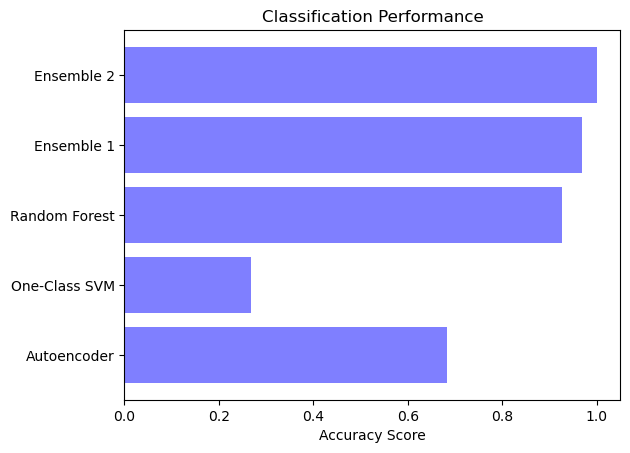

In [79]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

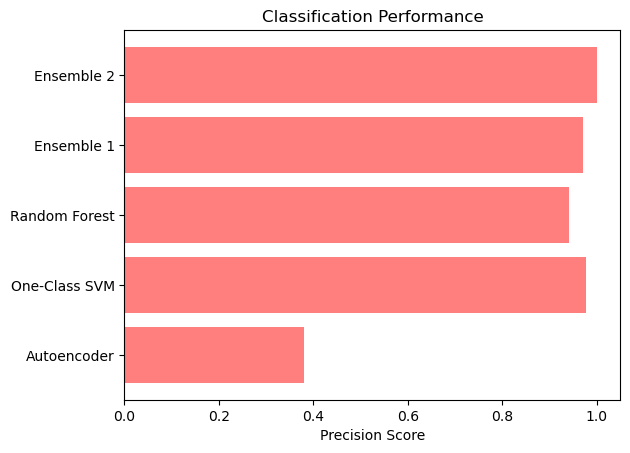

In [80]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

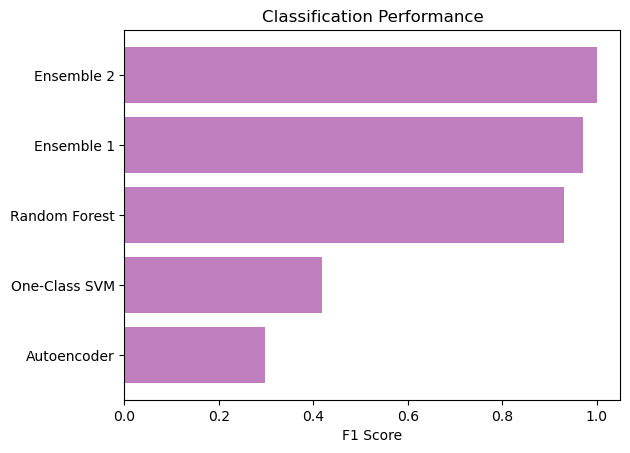

In [81]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='purple')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

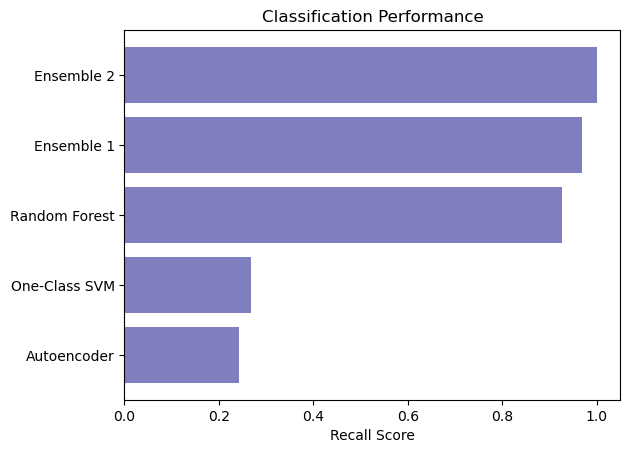

In [82]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()